# Object Detection

In [1]:
import keras
import keras_hub

images_path = keras.utils.get_file(
    "coco",
    "http://images.cocodataset.org/zips/train2017.zip",
    extract=True,
)
annotations_path = keras.utils.get_file(
    "annotations",
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip",
    extract=True,
)

/Users/yuhaochen/Developer/LearnDeepLearning/ObjectDetection/.pixi/envs/default/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


19336861798/19336861798 ━━━━━━━━━━━━━━━━━━━━ 632s 0us/step
252907541/252907541 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [3]:
import json

with open(f"{annotations_path}/annotations/instances_train2017.json", "r") as f:
    annotations = json.load(f)
    
images = {image["id"]: image for image in annotations["images"]}

def scale_box(box, width, height):
    scale = 1.0 / max(width, height)
    x, y, w, h = [v * scale for v in box]
    y += (height - width) * scale / 2 if height > width else 0
    y += (width - height)  * scale / 2 if width > height else 0
    return [x, y, w, h]

metadtata = {}

for annotation in annotations["annotations"]:
    id = annotation["image_id"]
    if id not in metadtata:
        metadtata[id] = { "boxes": [], "labels": [] }
    image = images[id]
    box = scale_box(annotation["bbox"], image["width"], image["height"])
    metadtata[id]["boxes"].append(box)
    metadtata[id]["labels"].append(annotation["category_id"])
    metadtata[id]["path"] = images_path + "/train2017/" + image["file_name"]

metadtata = list(metadtata.values())

In [4]:
len(metadtata)

117266

In [5]:
min([len(x["boxes"]) for x in metadtata])

1

In [6]:
max([len(x["boxes"]) for x in metadtata])

93

In [7]:
metadtata[435]

{'boxes': [[0.12471874999999999, 0.275, 0.57640625, 0.333703125],
  [0.0, 0.152078125, 0.7938125, 0.687640625],
  [0.0, 0.125140625, 1.0, 0.7498593750000001]],
 'labels': [17, 15, 2],
 'path': '/Users/yuhaochen/.keras/datasets/coco/train2017/000000171809.jpg'}

In [13]:
def coco_id_to_name(id):
    for category in annotations["categories"]:
        if category["id"] == id:
            return category["name"]
    return None

In [ ]:
[keras_hub.utils.coco_id_to_name(x) for x in metadtata[435]["labels"]]

['cat', 'bench', 'bicycle']

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.patches import Rectangle

color_map = {0: "gray"}

def label_to_color(label):
    if label not in color_map:
        h, s, v = (len(color_map) * 0.618) % 1, 0.5, 0.9
        color_map[label] = hsv_to_rgb((h, s, v))
    return color_map[label]

def draw_box(ax, box, text, color):
    x, y, w, h = box
    ax.add_patch(Rectangle((x, y), w, h, lw=2, ec=color, fc="none"))
    textbox = dict(fc=color, pad=1, ec="none")
    ax.text(x, y, text, c="white", size=10, va="bottom", bbox=textbox)

def draw_image(ax, image):
    ax.set(xlim=(0, 1), ylim=(1, 0), xticks=[], yticks=[], aspect="equal")
    image = plt.imread(image)
    height, width = image.shape[:2]
    hpad = (1 - height / width) / 2 if width > height else 0
    wpad = (1 - width / height) / 2 if height > width else 0
    extent = [wpad, 1 - wpad, 1 - hpad, hpad]
    ax.imshow(image, extent=extent)

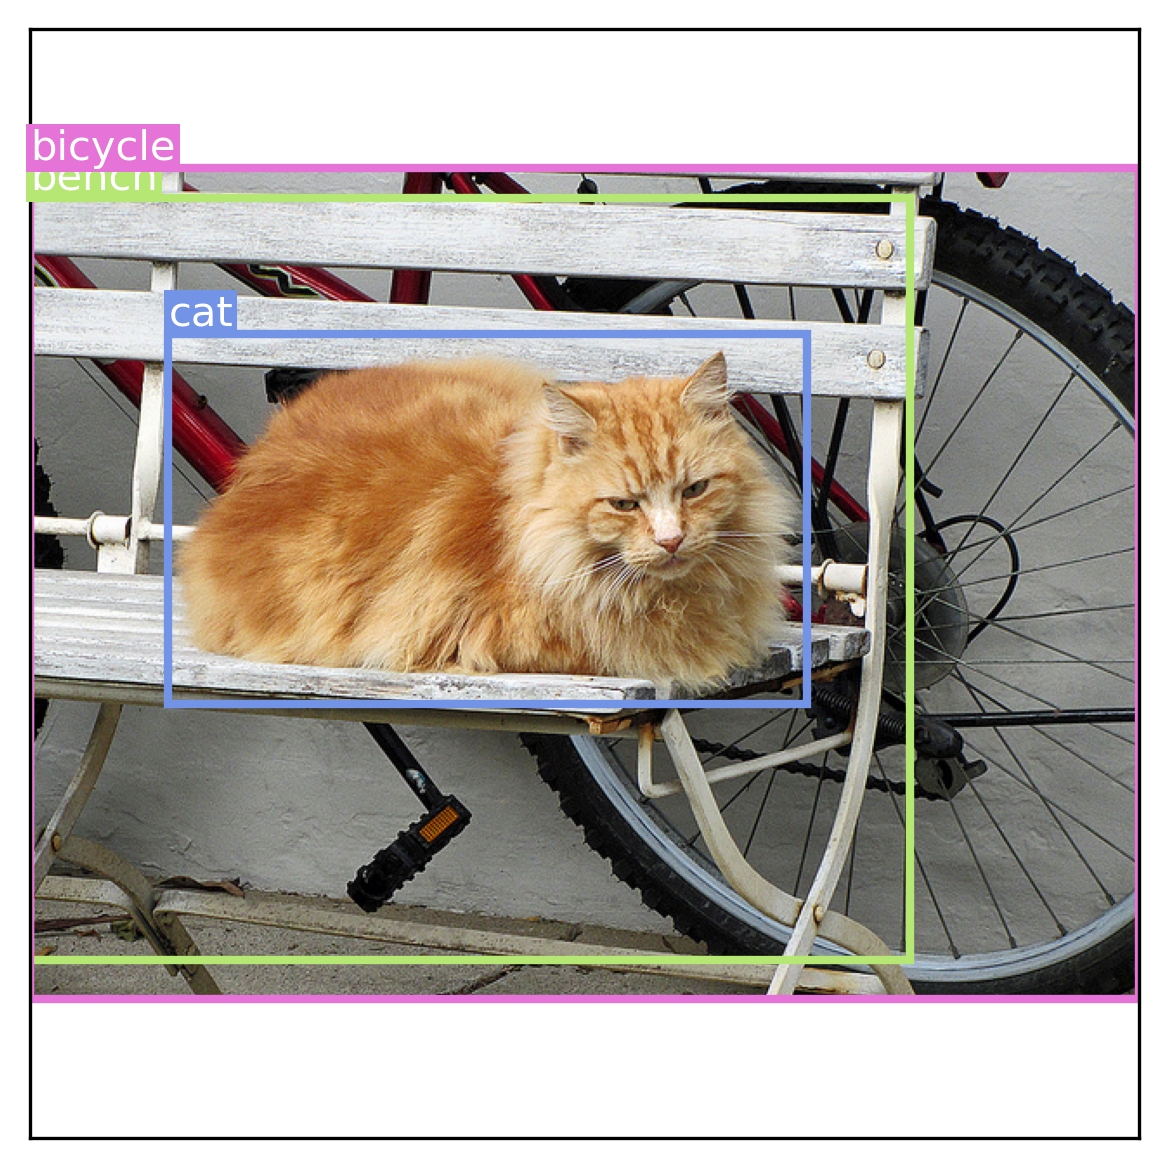

In [18]:
sample = metadtata[435]
ig, ax = plt.subplots(dpi=300)
draw_image(ax, sample["path"])
for box, label in zip(sample["boxes"], sample["labels"]):
    label_name = coco_id_to_name(label)
    draw_box(ax, box, label_name, label_to_color(label))
plt.show()


In [19]:
import random

metadtata = list(filter(lambda x: len(x["boxes"]) <= 4, metadtata))
random.shuffle(metadtata)

In [21]:
image_size = 448

backbone = keras_hub.models.Backbone.from_preset(
    "resnet_50_imagenet",
)
preprocessor = keras_hub.layers.ImageConverter.from_preset(
    "resnet_50_imagenet",
    image_size=(image_size, image_size),
)

100%|██████████| 841/841 [00:00<00:00, 450kB/s]


100%|██████████| 90.3M/90.3M [00:15<00:00, 6.26MB/s]


100%|██████████| 873/873 [00:00<00:00, 910kB/s]


In [26]:
from tensorflow import keras
from keras import layers

grid_size = 6
num_labels = 91

inputs = keras.Input(shape=(image_size, image_size, 3))
x = backbone(inputs)
x = layers.Conv2D(512, (3, 3), strides=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation="relu", kernel_initializer="glorot_normal")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(grid_size * grid_size * (num_labels + 5))(x)
x = layers.Reshape((grid_size, grid_size, num_labels + 5))(x)
box_predictions = x[..., :5]
class_predictions = layers.Activation("softmax")(x[..., 5:])
outputs = {"box": box_predictions, "class": class_predictions}
model = keras.Model(inputs, outputs)

In [27]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 448, 448,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_net_backbone    │ (None, 14, 14,    │ 23,561,152 │ input_layer_3[0]… │
│ (ResNetBackbone)    │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 6, 512) │  9,437,696 │ res_net_backbone… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 18432)     │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2048)      │ 37,750,784 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3456)      │  7,081,344 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 6, 6, 96)  │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 6, 6, 91)  │          0 │ reshape_2[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 6, 6, 5)   │          0 │ reshape_2[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 6, 6, 91)  │          0 │ get_item_5[0][0]  │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,830,976 (296.90 MB)

 Trainable params: 77,777,856 (296.70 MB)

 Non-trainable params: 53,120 (207.50 KB)